In [1]:
!pip install timm

     |████████████████████████████████| 431 kB 4.2 MB/s 


In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"longwei123","key":"753b9d3ccb5a72fafed9c0e1b3956402"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.transforms import transforms, autoaugment
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
%matplotlib inline
from torchvision.datasets import ImageFolder
import timm

In [4]:
! kaggle datasets download -d puneet6060/intel-image-classification

 96% 334M/346M [00:04<00:00, 98.3MB/s]
100% 346M/346M [00:04<00:00, 75.6MB/s]


In [5]:
!unzip intel-image-classification -d data_set

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: data_set/seg_train/seg_train/mountain/7506.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7537.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7539.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7551.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7560.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7565.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7578.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7581.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7586.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7647.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7652.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7654.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7662.jpg  
  inflating: data_set/seg_train/seg_train/mountain/767.jpg  
  inflating: data_set/seg_train/seg_train/mountain/7672.jpg  
  inflating: data_set/seg_train/seg_train/mo

In [6]:
train_data_dir  = '/content/data_set/seg_train/seg_train'
data_norm_mean = (0.4272369, 0.44893023, 0.44566408)
data_norm_std = (0.2661989, 0.26563218, 0.2907933)
transformationtrain = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
 ])
train_data = ImageFolder(train_data_dir, transform = transformationtrain)

In [7]:
val_data_dir  = '/content/data_set/seg_test/seg_test'
transformationtest = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
 ])
val_data = ImageFolder(val_data_dir, transform = transformationtest)

val_data, test_data = random_split(val_data, [1500, 1500])

In [8]:
trainDataLoader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True)
valDataLoader = torch.utils.data.DataLoader(val_data,batch_size=32,shuffle=False)
testDataLoader = torch.utils.data.DataLoader(test_data,batch_size=32,shuffle=False)

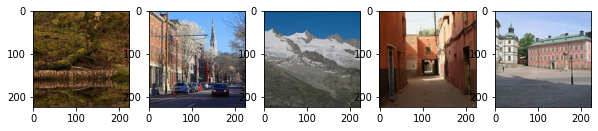

In [9]:
images, labels = iter(trainDataLoader).next()

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.imshow(np.stack((images[index][0], images[index][1], images[index][2]), axis=2))

In [10]:
def trains(epochs, model, lr, save_loss, save_acc, trainDataLoader, valDataLoader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  save_loss = save_loss
  save_acc = save_acc
  trainDataLoader = trainDataLoader
  testDataLoader = valDataLoader
  for epoch in range(epochs):
    model.train()
    current_loss = 0.0
    current_corrects = 0
    for batch_idx, (inputs, labels) in enumerate(trainDataLoader):
      # print(batch_idx)
      inputs = inputs.cuda()
      labels = labels.cuda()
      model.cuda()
      optimizer.zero_grad()

      with torch.set_grad_enabled(True):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
      
      current_loss += loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)

    save_loss['train'] += [current_loss / len(trainDataLoader.dataset)]
    save_acc['train'] += [current_corrects.float() / len(trainDataLoader.dataset)]
    # pretty print
    print(f"Epoch:{epoch} -- Phase:{'train'} -- Loss:{save_loss['train'][-1]:.2f} -- Acc:{save_acc['train'][-1]*100:.2f}")

    model.eval()
    current_loss = 0.0
    current_corrects = 0
    for batch_idx, (inputs, labels) in enumerate(testDataLoader):
      # print(batch_idx)
      inputs = inputs.cuda()
      labels = labels.cuda()
      optimizer.zero_grad()

      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      current_loss += loss.item() * inputs.size(0)
      current_corrects += torch.sum(preds == labels.data)

    save_loss['val'] += [current_loss / len(testDataLoader.dataset)]
    save_acc['val'] += [current_corrects.float() / len(testDataLoader.dataset)]
    # pretty print
    print(f"Epoch:{epoch} -- Phase:{'val'} -- Loss:{save_loss['val'][-1]:.2f} -- Acc:{save_acc['val'][-1]*100:.2f}")

In [11]:
def tests(model, test_loss, test_acc, testDataLoader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=5.5e-5)
  model.eval()
  current_loss = 0.0
  current_corrects = 0
  for batch_idx, (inputs, labels) in enumerate(testDataLoader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    current_loss += loss.item() * inputs.size(0)
    current_corrects += torch.sum(preds == labels.data)

  test_loss = current_loss / len(testDataLoader.dataset)
  test_acc = current_corrects.float() / len(testDataLoader.dataset)
  # pretty print
  print(f"Epoch:{1} -- Phase:{'test'} -- Loss:{test_loss:.2f} -- Acc:{test_acc*100:.2f}")
  return test_loss, test_acc

In [12]:
from pprint import pprint
model_names = timm.list_models('vit*',pretrained=True)
pprint(model_names)

['vit_base_patch8_224',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_384',
 'vit_base_patch16_sam_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_patch32_sam_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224_in21k',
 'vit_large_patch32_384',
 'vit_large_r50_s32_224',
 'vit_large_r50_s32_224_in21k',
 'vit_large_r50_s32_384',
 'vit_small_patch16_224',
 'vit_small_patch16_224_in21k',
 'vit_small_patch16_384',
 'vit_small_patch32_224',
 'vit_small_patch32_224_in21k',
 'vit_small_patch32_384',
 'vit_small_r26_s32_224',
 'vit_small_r26_s32_224_in21k',
 'vit_small_r26_s32_384',
 'vit_tiny_patch16_224',
 'vit_tiny_patch16_224_in21k',
 'vit_tiny_patch16_384',
 'vit_tiny_r_s

##2.2 Using pretrained models

###2.2.1 Pretrained Resnet50 model with ImageNet Dataset

In [13]:
model_res50_pre_in1k = timm.create_model('resnet50', pretrained=True, num_classes=len(train_data.classes))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [14]:
save_loss4 = {'train':[], 'val':[]}
save_acc4 = {'train':[], 'val':[]}

In [15]:
trains(10, model_res50_pre_in1k, 5.5e-5, save_loss4, save_acc4, trainDataLoader, valDataLoader)

Epoch:0 -- Phase:train -- Loss:0.99 -- Acc:74.16
Epoch:0 -- Phase:val -- Loss:0.34 -- Acc:89.00
Epoch:1 -- Phase:train -- Loss:0.29 -- Acc:90.97
Epoch:1 -- Phase:val -- Loss:0.24 -- Acc:91.07
Epoch:2 -- Phase:train -- Loss:0.22 -- Acc:92.70
Epoch:2 -- Phase:val -- Loss:0.22 -- Acc:92.27
Epoch:3 -- Phase:train -- Loss:0.19 -- Acc:93.49
Epoch:3 -- Phase:val -- Loss:0.20 -- Acc:92.60
Epoch:4 -- Phase:train -- Loss:0.16 -- Acc:94.39
Epoch:4 -- Phase:val -- Loss:0.20 -- Acc:92.73
Epoch:5 -- Phase:train -- Loss:0.13 -- Acc:95.44
Epoch:5 -- Phase:val -- Loss:0.20 -- Acc:93.27
Epoch:6 -- Phase:train -- Loss:0.12 -- Acc:95.87
Epoch:6 -- Phase:val -- Loss:0.20 -- Acc:93.13
Epoch:7 -- Phase:train -- Loss:0.10 -- Acc:96.52
Epoch:7 -- Phase:val -- Loss:0.21 -- Acc:93.07
Epoch:8 -- Phase:train -- Loss:0.09 -- Acc:96.81
Epoch:8 -- Phase:val -- Loss:0.21 -- Acc:93.20
Epoch:9 -- Phase:train -- Loss:0.07 -- Acc:97.78
Epoch:9 -- Phase:val -- Loss:0.24 -- Acc:92.00


###2.2.2 Pretrained Vit-base model with ImageNet Dataset

In [16]:
model_vit_pre_in1k = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_data.classes))

In [17]:
save_loss5 = {'train':[], 'val':[]}
save_acc5 = {'train':[], 'val':[]}

In [ ]:
trains(5, model_vit_pre_in1k, 5.5e-5, save_loss5, save_acc5, trainDataLoader, valDataLoader)

Epoch:0 -- Phase:train -- Loss:0.24 -- Acc:91.99
Epoch:0 -- Phase:val -- Loss:0.18 -- Acc:93.53


###2.2.3 Pretrained Resnet50 model with ImageNet-21K Dataset

In [ ]:
model_res50 = timm.create_model('resnet50', pretrained=False, num_classes=11221)

In [ ]:
import torch.distributed as dist


def get_dist_info():
    initialized = dist.is_available() and dist.is_initialized()
    if initialized:
        rank = dist.get_rank()
        world_size = dist.get_world_size()
    else:
        rank = 0
        world_size = 1
    return rank, world_size


def is_master():
    rank, _ = get_dist_info()
    return rank == 0


def print_at_master(str):
    if is_master():
        print(str)
def load_model_weights(model, model_path):
    state = torch.load(model_path, map_location='cpu')
    for key in model.state_dict():
        if 'num_batches_tracked' in key:
            continue
        p = model.state_dict()[key]
        if key in state['state_dict']:
            ip = state['state_dict'][key]
            if p.shape == ip.shape:
                p.data.copy_(ip.data)  # Copy the data of parameters
            else:
                print_at_master(
                    'could not load layer: {}, mismatch shape {} ,{}'.format(key, (p.shape), (ip.shape)))
        else:
            print_at_master('could not load layer: {}, not in checkpoint'.format(key))
    return model

In [ ]:
model_res50_pre_in21k = load_model_weights(model_res50, "/content/resnet50_miil_21k.pth")

In [ ]:
num_ftrs = model_res50_pre_in21k.fc.in_features
model_res50_pre_in21k.fc = nn.Linear(num_ftrs, len(train_data.classes))

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model_res50_pre_in21k))

23520326


In [ ]:
save_loss6 = {'train':[], 'val':[]}
save_acc6 = {'train':[], 'val':[]}

In [ ]:
trains(5, model_res50_pre_in21k, 5.5e-5, save_loss6, save_acc6, trainDataLoader, valDataLoader)

Epoch:0 -- Phase:train -- Loss:0.42 -- Acc:88.26
Epoch:0 -- Phase:val -- Loss:0.19 -- Acc:93.93
Epoch:1 -- Phase:train -- Loss:0.18 -- Acc:94.01
Epoch:1 -- Phase:val -- Loss:0.16 -- Acc:94.60
Epoch:2 -- Phase:train -- Loss:0.14 -- Acc:95.30
Epoch:2 -- Phase:val -- Loss:0.18 -- Acc:93.93
Epoch:3 -- Phase:train -- Loss:0.10 -- Acc:96.71
Epoch:3 -- Phase:val -- Loss:0.17 -- Acc:94.53
Epoch:4 -- Phase:train -- Loss:0.07 -- Acc:97.90
Epoch:4 -- Phase:val -- Loss:0.18 -- Acc:94.00


###2.2.4 Pretrained Vit-base model with ImageNet-21K Dataset

In [ ]:
model_vit_pre_in21k = timm.create_model('vit_base_patch16_224_miil_in21k', pretrained=True, num_classes=len(train_data.classes))

In [ ]:
print(count_parameters(model_vit_pre_in21k))

85775622


In [ ]:
save_loss7 = {'train':[], 'val':[]}
save_acc7 = {'train':[], 'val':[]}

In [ ]:
trains(5, model_vit_pre_in21k, 5.5e-5, save_loss7, save_acc7, trainDataLoader, valDataLoader)

Epoch:0 -- Phase:train -- Loss:0.20 -- Acc:93.25
Epoch:0 -- Phase:val -- Loss:0.18 -- Acc:94.07
Epoch:1 -- Phase:train -- Loss:0.11 -- Acc:95.92
Epoch:1 -- Phase:val -- Loss:0.15 -- Acc:94.33
Epoch:2 -- Phase:train -- Loss:0.08 -- Acc:97.38
Epoch:2 -- Phase:val -- Loss:0.19 -- Acc:93.80
Epoch:3 -- Phase:train -- Loss:0.06 -- Acc:98.05
Epoch:3 -- Phase:val -- Loss:0.20 -- Acc:94.20
Epoch:4 -- Phase:train -- Loss:0.04 -- Acc:98.71
Epoch:4 -- Phase:val -- Loss:0.25 -- Acc:94.07


###2.2.5 Result

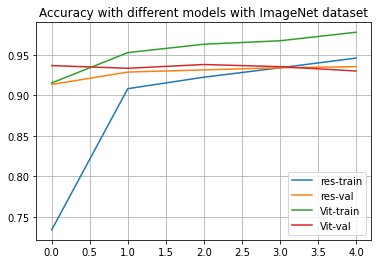

In [ ]:
plt.plot(torch.tensor(save_acc4['train']))
plt.plot(torch.tensor(save_acc4['val']))
plt.plot(torch.tensor(save_acc5['train']))
plt.plot(torch.tensor(save_acc5['val']))
plt.legend(["res-train", "res-val", "Vit-train", "Vit-val"])
plt.title("Accuracy with different models with ImageNet dataset")
plt.grid()

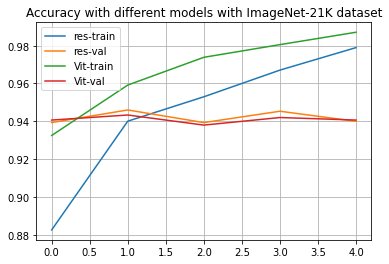

In [ ]:
plt.plot(torch.tensor(save_acc6['train']))
plt.plot(torch.tensor(save_acc6['val']))
plt.plot(torch.tensor(save_acc7['train']))
plt.plot(torch.tensor(save_acc7['val']))
plt.legend(["res-train", "res-val", "Vit-train", "Vit-val"])
plt.title("Accuracy with different models with ImageNet-21K dataset")
plt.grid()

In [ ]:
test_loss4 = 0.0
test_acc4 = 0.0
test_loss4, test_acc4 = tests(model_res50_pre_in1k, test_loss4, test_acc4, testDataLoader)

Epoch:1 -- Phase:test -- Loss:0.17 -- Acc:93.27


In [ ]:
test_loss5 = 0.0
test_acc5 = 0.0
test_loss5, test_acc5 = tests(model_vit_pre_in1k, test_loss5, test_acc5, testDataLoader)

Epoch:1 -- Phase:test -- Loss:0.30 -- Acc:92.27


In [ ]:
test_loss6 = 0.0
test_acc6 = 0.0
test_loss6, test_acc6 = tests(model_res50_pre_in21k, test_loss6, test_acc6, testDataLoader)

Epoch:1 -- Phase:test -- Loss:0.20 -- Acc:93.60


In [ ]:
test_loss7 = 0.0
test_acc7 = 0.0
test_loss7, test_acc7 = tests(model_vit_pre_in21k, test_loss7, test_acc7, testDataLoader)

Epoch:1 -- Phase:test -- Loss:0.20 -- Acc:94.80


Resnet50 performs well when pre-trained on a medium ImageNet dataset since the Vision Transformer has fewer inductive biases for vision than Resnet50. However, the Vision Transformer performs well when pre-trained on a large ImageNet-21K dataset.